In [1]:
import yaml
 
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [1]:
import pandas as pd

df = pd.read_csv("../data/clean/alzheimers_top5.csv")
df

,FunctionalAssessment,ADL,MemoryComplaints,MMSE,BehavioralProblems,Diagnosis
0,6.518877,1.725883,0,21.463532,0,0
1,7.118696,2.592424,0,20.613267,0,0
2,5.895077,7.119548,0,7.356249,0,0
3,8.965106,6.481226,0,13.991127,1,0
4,6.045039,0.014691,0,13.517609,0,0
...,...,...,...,...,...,...
2144,0.238667,4.492838,0,1.201190,0,1
2145,8.687480,9.204952,0,6.458060,1,1
2146,1.972137,5.036334,0,17.011003,0,1
2147,5.173891,3.785399,0,4.030491,0,1


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

Cross-Validation Scores: [0.94186047 0.90988372 0.94476744 0.93023256 0.88921283]
Mean CV Accuracy: 0.9231914028069699
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best Parameters Found: {'estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9482168282595431

Test Accuracy: 0.958139534883721

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       267
           1       0.96      0.93      0.94       163

    accuracy                           0.96       430
   macro avg       0.96      0.95      0.96       430
weighted avg       0.96      0.96      0.96       430



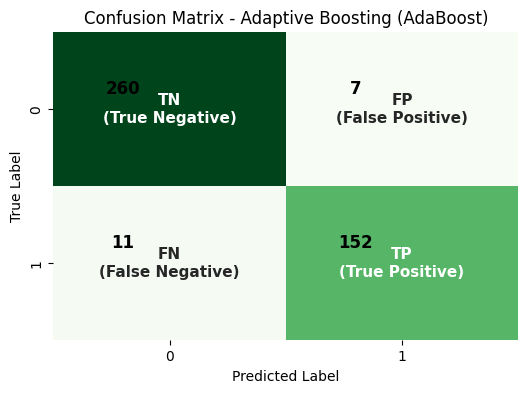

In [3]:
# ================================================
# ADAPTIVE BOOSTING (AdaBoost) - ENSEMBLE METHOD
# ================================================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# ================================================
# STEP 0 — Data Preparation
# ================================================
# 1. Separate features and target
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]
# 2. Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
# 3. Standardize features (optional for trees)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ================================================
# STEP 1 — Cross-Validation (5 folds)
# ================================================
# Base estimator: simple Decision Tree (stump)
base_tree = DecisionTreeClassifier(max_depth=1, random_state=0)
# Initialize AdaBoost classifier
ada = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=100,     # number of weak learners
    learning_rate=0.1,    # controls the contribution of each tree
    random_state=0
)
# Cross-validation
cv_scores = cross_val_score(ada, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
# ================================================
# STEP 2 — Grid Search for Hyperparameter Optimization
# ================================================
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]  # depth of each weak learner
}
grid = GridSearchCV(
    AdaBoostClassifier(estimator=base_tree, random_state=0),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_scaled, y_train)
print("\nBest Parameters Found:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)
# ================================================
# STEP 3 — Evaluate Tuned Model on Test Set
# ================================================
best_ada = grid.best_estimator_
y_pred = best_ada.predict(X_test_scaled)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# ================================================
# STEP 4 — Confusion Matrix with Labels
# ================================================
cm = confusion_matrix(y_test, y_pred)
# Create labeled annotations for each cell
labels = [
    ["TN\n(True Negative)", "FP\n(False Positive)"],
    ["FN\n(False Negative)", "TP\n(True Positive)"]
]
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=labels, fmt='', cmap="Greens", cbar=False, annot_kws={"fontsize":11, "weight":"bold"})
plt.title("Confusion Matrix - Adaptive Boosting (AdaBoost)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# Add numeric values on top of text
for i in range(2):
    for j in range(2):
        plt.text(j + 0.3, i + 0.3, f"\n{cm[i, j]}", color="black", ha='center', va='center', fontsize=12, weight="bold")
plt.show()